# Deconvolution Benchmark: Julia

---
## Setup

In [3]:
using DeconvOptim, TestImages, Colors, ImageIO, Noise, ImageShow, Images, Plots, BenchmarkTools, FFTW

---
## Test Image

Una vez importados los paquetes lo que hemos hecho ha sido coger una imagen de prueba, añadirla borrosidad y ruido y hacer la deconvolución en 2D sin regularizar.
Usaremos la misma PSF para el código en python y el mismo número de iteraciones.


In [5]:
# Cargar la imagen de prueba
img = load("ImagenPrueba.jpg")
img = Float32.(img)

# Generar la PSF (Point Spread Function)
psf = Float32.(generate_psf(size(img), 30))

# Crear una versión borrosa y ruidosa de la imagen
img_b = conv(img, psf)  # Imagen borrosa
img_n = poisson(img_b, 300)  # Imagen borrosa y ruidosa

# Guardar la imagen borrosa y ruidosa
# save("blurrednoisy_img.jpg", img_b)

# Deconvolución 2D sin regularizador
res_no_reg, o = deconvolution(img_n, psf, regularizer=nothing, iterations=30)

# Medir el tiempo de ejecución de la deconvolución

b = @benchmark  deconvolution(img_n, psf, regularizer=nothing, iterations=30) samples=15 evals=1

BenchmarkTools.Trial: 7 samples with 1 evaluation.
 Range (min … max):  417.394 ms …    1.123 s  ┊ GC (min … max):  1.42% … 56.47%
 Time  (median):     652.502 ms               ┊ GC (median):    34.55%
 Time  (mean ± σ):   659.326 ms ± 239.229 ms  ┊ GC (mean ± σ):  32.00% ± 19.29%

  █  █    █           █     ██                                █  
  █▁▁█▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁██▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  417 ms           Histogram: frequency by time          1.12 s <

 Memory estimate: 172.58 MiB, allocs estimate: 5827.

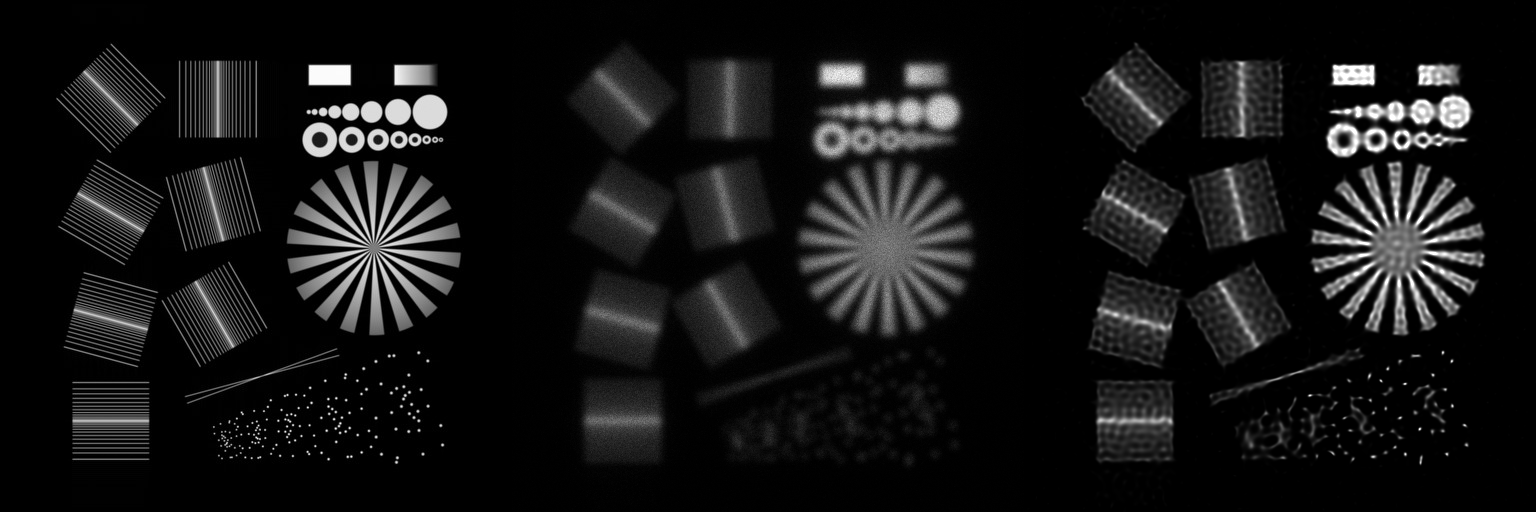

In [6]:
# Mostrar los resultados finales junto a la versión original y la versión borrosa
Gray.([img img_n res_no_reg])

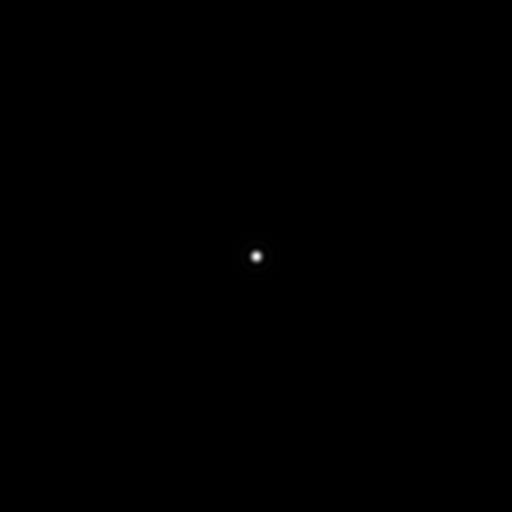

In [7]:
# Suponemos que psf ya está definida
# Normaliza los valores de la PSF al rango [0, 1]
psf_min = minimum(psf)
psf_max = maximum(psf)
psf_normalized = (psf .- psf_min) ./ (psf_max - psf_min)
psf_gray = Gray.(psf_normalized)  # Convertir a escala de grises

# Centrar la PSF utilizando ifftshift
centered_psf = ifftshift(psf_normalized)
centered_psf_gray = Gray.(centered_psf)  # Convertir a escala de grises

# Guardar la PSF normalizada como una imagen JPEG
# save("psf.jpg", centered_psf_gray)

# Mostrar la PSF centrada
display(centered_psf_gray)


Ahora vamos a usar la función richardson_lucy_iterative del módulo deconvoptim.jl sin regularización.

In [9]:
# Deconvolución iterativa de Richardson-Lucy sin regularizador
restored_img = richardson_lucy_iterative(img_n, psf; regularizer=nothing, iterations=30);

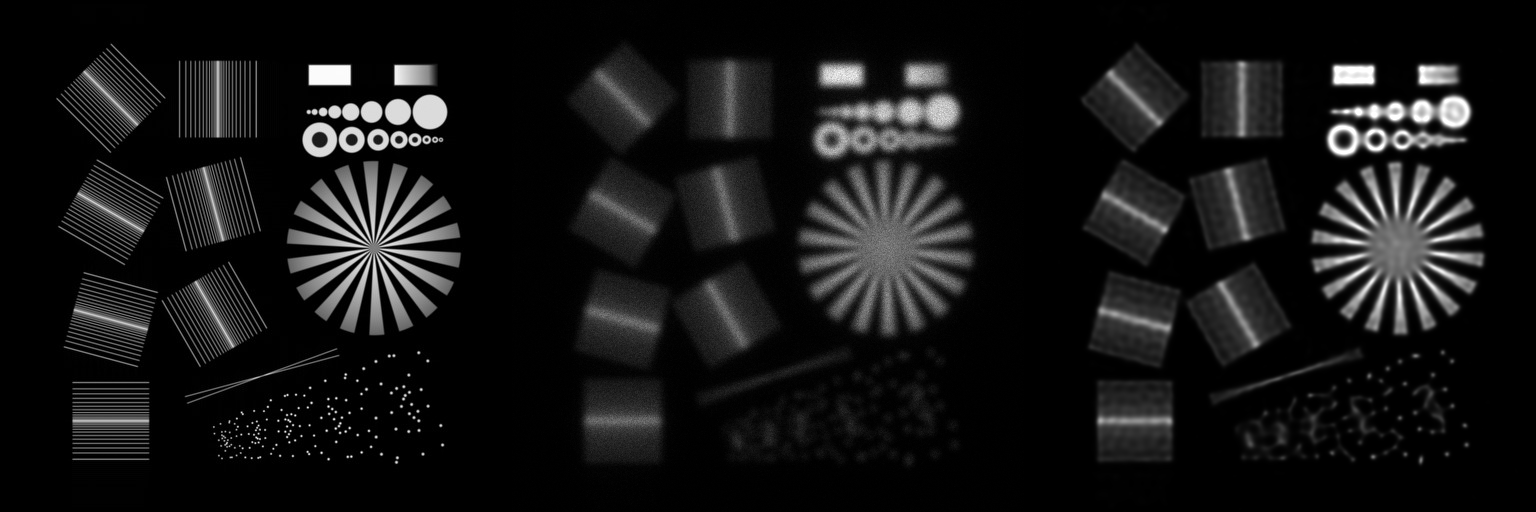

In [10]:
Gray.([img img_n restored_img])

In [11]:
c = @benchmark richardson_lucy_iterative(img_n, psf; regularizer=nothing, iterations=30) samples=100 evals=1 seconds=60

BenchmarkTools.Trial: 100 samples with 1 evaluation.
 Range (min … max):   95.578 ms … 146.243 ms  ┊ GC (min … max): 0.00% … 2.92%
 Time  (median):     104.970 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   107.694 ms ±   9.677 ms  ┊ GC (mean ± σ):  0.61% ± 1.75%

     ▄▃█▆▆▃  ▁▃▁ ▁     ▄   ▃                                     
  ▄▄▁██████▇▇███▇█▁▁▇▇▄█▁▇▁█▄▄▁▄▁▁▄▁▁▄▁▄▆▁▄▁▁▄▁▁▁▁▁▁▄▁▁▁▁▁▁▁▁▁▄ ▄
  95.6 ms          Histogram: frequency by time          143 ms <

 Memory estimate: 7.01 MiB, allocs estimate: 33.

Veremos ahora ejemplos con TV regularization en Julia

In [13]:
# Deconvolución iterativa de Richardson-Lucy con regularizador
optim_res = richardson_lucy_iterative(img_n, psf, λ=0.05, regularizer=TV(), iterations=30)
d1 = @benchmark richardson_lucy_iterative(img_n, psf, λ=0.05, regularizer=TV(), iterations=30) samples=100 evals=1 seconds=60

BenchmarkTools.Trial: 70 samples with 1 evaluation.
 Range (min … max):  782.701 ms …   1.004 s  ┊ GC (min … max): 1.55% … 2.35%
 Time  (median):     848.621 ms              ┊ GC (median):    1.71%
 Time  (mean ± σ):   851.957 ms ± 45.815 ms  ┊ GC (mean ± σ):  1.80% ± 0.51%

       ▂  ▂  ▂       ▂   ▂▅    █                                
  ▅▅█▁▅█████▅███▁▁▁████▅▅██▅██▁██▁█▅▁▁▁▅▁▅▁▅▅▁▅▅▅▁▁▅▅▁▅▁▁▁▁▁▁▅ ▁
  783 ms          Histogram: frequency by time          964 ms <

 Memory estimate: 76.56 MiB, allocs estimate: 633694.

In [14]:
# Deconvolución iterativa de Richardson-Lucy con regularizador (optimizada)
tv = TV()

#677 (generic function with 1 method)

In [15]:
d2 = @benchmark richardson_lucy_iterative(img_n, psf, λ=0.05, regularizer=tv, iterations=30) samples=100 evals=1 seconds=60

BenchmarkTools.Trial: 100 samples with 1 evaluation.
 Range (min … max):  134.956 ms … 175.986 ms  ┊ GC (min … max): 0.00% … 1.99%
 Time  (median):     146.323 ms               ┊ GC (median):    1.73%
 Time  (mean ± σ):   149.476 ms ±  10.207 ms  ┊ GC (mean ± σ):  1.42% ± 1.15%

   ▁        ▁     █▃                                             
  ▇█▄▆▁▆▆▇▇▆█▇▄▆▇▇██▆▆▇▇▇▆▄▁▄▁▄▄▆▄▆▆▁▇▄▆▆▄▁▄▄▄▆▁▁▁▄▄▁▄▁▁▁▁▁▆▆▁▄ ▄
  135 ms           Histogram: frequency by time          175 ms <

 Memory estimate: 38.04 MiB, allocs estimate: 1057.

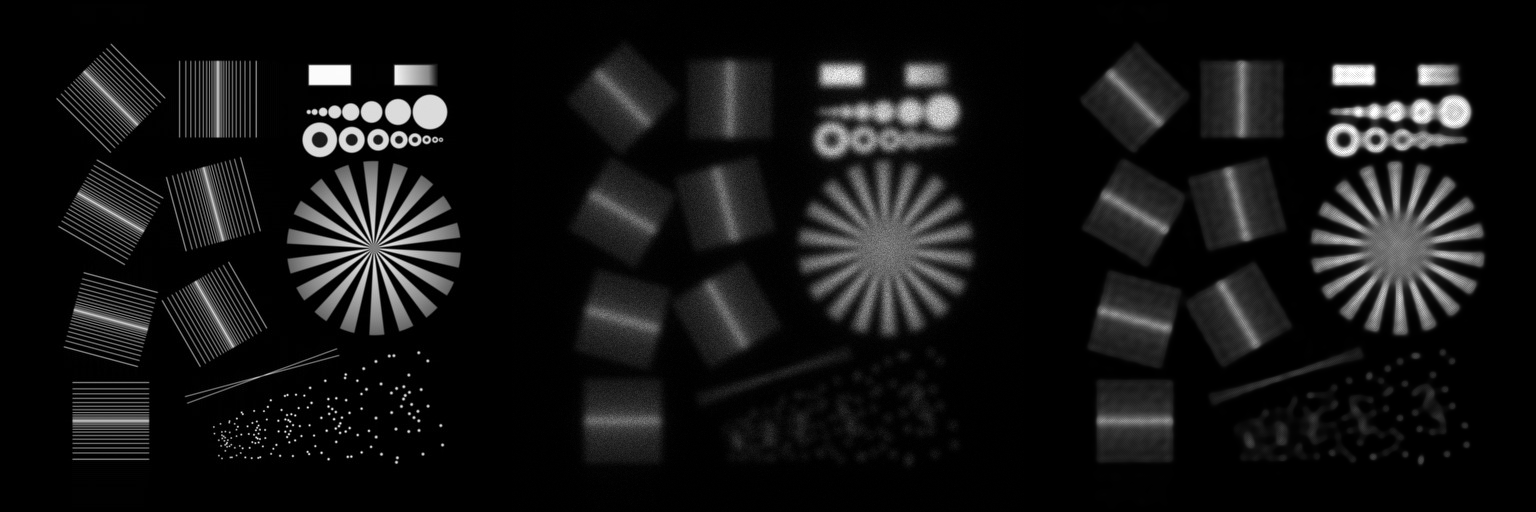

In [16]:
Gray.([img img_n optim_res])

---
## Cell
Test usando solo el plano central del `cells3D` dataset

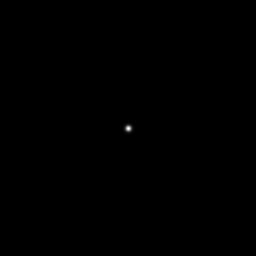

In [18]:
img = load("cells3d_convolved.tif")
img = Float32.(img)

psf = load("cells3d_psf.tif")
psf = Float32.(psf);

Gray.(psf/maximum(psf))

In [19]:
ipsf = ifftshift(psf);

In [20]:
deconvolved = richardson_lucy_iterative(img, ipsf; regularizer=nothing, iterations=30);

In [21]:
 c = @benchmark richardson_lucy_iterative(img, ipsf; regularizer=nothing, iterations=30) samples=100 evals=1 seconds=60

BenchmarkTools.Trial: 100 samples with 1 evaluation.
 Range (min … max):  25.448 ms … 41.880 ms  ┊ GC (min … max): 0.00% … 32.61%
 Time  (median):     26.656 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   27.384 ms ±  2.397 ms  ┊ GC (mean ± σ):  0.95% ±  4.52%

   ▁ █▇▁ ▁                                                     
  ▄█▆███▇██▄▄▅▃▃▃▁▄▁▁▁▁▁▄▁▁▃▁▁▁▁▁▃▁▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃ ▃
  25.4 ms         Histogram: frequency by time        39.5 ms <

 Memory estimate: 1.76 MiB, allocs estimate: 33.

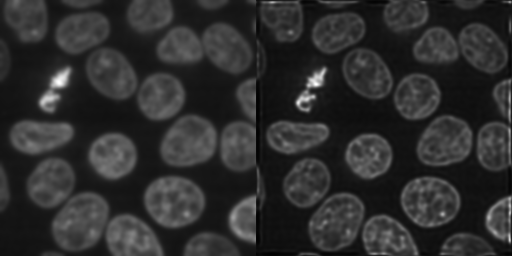

In [22]:
Gray.([img/maximum(img) deconvolved/maximum(deconvolved)])